In [589]:
# import libraries
from scipy import stats
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import numpy as np
import pandas as pd
import pandas_ta as ta
import xgboost as xgb
import yfinance as yf
#
import warnings
warnings.filterwarnings('ignore')

In [590]:
# utils

def calc_sma(df: pd.DataFrame, length: int):
    df[f'SMA_{length}'] = df['Adj Close'].rolling(window=length).mean()
    df[f'SMA_{length}'] = (df[f'SMA_{length}']-df['Adj Close'])/df['Adj Close']
    return df[f'SMA_{length}']

def corr_ind_ret(df: pd.DataFrame, indi: str):
    # Compute correlation between SMA and daily returns
    corr = np.corrcoef(df[indi].values, df['Return'].values)[0, 1]
    # Print correlation coefficient
    print(f"Correlation coefficient between {indi} and daily returns: ", corr)

    # Plot scatter plot with linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[indi], df['Return'])
    line = slope * df[indi] + intercept
    plt.scatter(df[indi], df['Return'])
    plt.plot(df[indi], line, color='red')
    plt.xlabel(indi)
    plt.ylabel('Daily Returns')
    plt.title(f'{indi} vs Daily Returns')
    plt.show()

# functions for model performance evaluation
def MAE(y_true, y_hat):
    return np.mean(np.abs(y_true - y_hat))

def MSE(y_true, y_hat):
    return np.mean(np.square(y_true - y_hat))

def RMSE(y_true, y_hat):
    return np.sqrt(MSE(y_true, y_hat))

In [591]:
# Load historical data
ticker = 'MSFT'
df = yf.download(ticker)
df = df.iloc[1:]
# df = df['Adj Close']

# Calculate SMA with a 20-day window
sma_windows = [7, 20, 50]
for sma_window in sma_windows:
    df[f'SMA_{sma_window}'] = calc_sma(df, sma_window)
# Calculate RSI with a 14-day window using pandas_ta library
df.ta.rsi(length=14, append=True)

df.ta.adx(length=14, append=True)

# Compute daily returns
df['Return'] = df['Adj Close'].pct_change().shift(-1)
df['Return_L1'] = df['Return'].shift(1)
# df['Return_L1'] = df['Return']

df = df.dropna()

[*********************100%***********************]  1 of 1 completed


In [592]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_20,SMA_50,RSI_14,ADX_14,DMP_14,DMN_14,Return,Return_L1
Date,,,,,,,,,,,,,,,
2010-09-09,1.400000,1.403333,1.379333,1.380667,1.380667,5643000,-0.005381,-0.050580,-0.045389,55.079922,15.327226,27.650381,17.091029,-0.026074,-0.009090
2010-09-10,1.383333,1.395333,1.317333,1.344667,1.344667,5799000,0.026135,-0.018791,-0.023461,50.577318,14.404179,24.887226,23.326393,0.027268,-0.026074
2010-09-13,1.392667,1.393333,1.366667,1.381333,1.381333,5412000,0.000759,-0.039044,-0.050579,54.644094,13.555780,23.321297,21.858672,0.019305,0.027268
2010-09-14,1.369333,1.440000,1.368667,1.408000,1.408000,9820500,-0.017790,-0.051705,-0.066742,57.390266,13.695558,27.124977,19.883776,0.040719,0.019305
2010-09-15,1.398667,1.466667,1.386000,1.465333,1.465333,10269000,-0.050175,-0.082370,-0.097916,62.629183,14.281808,27.713090,17.912830,-0.047315,0.040719


In [593]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_20,SMA_50,RSI_14,ADX_14,DMP_14,DMN_14,Return,Return_L1
Date,,,,,,,,,,,,,,,
2023-03-28,192.000000,192.350006,185.429993,189.190002,189.190002,98654600,0.008518,-0.011734,-0.031015,51.442472,14.918908,24.820635,23.290849,0.024790,-0.013659
2023-03-29,193.130005,195.289993,189.440002,193.880005,193.880005,123660000,-0.008046,-0.037933,-0.048019,54.784327,14.402267,25.906780,22.208658,0.007221,0.024790
2023-03-30,195.580002,197.330002,194.419998,195.279999,195.279999,110252200,-0.016840,-0.043709,-0.048034,55.763037,14.144152,26.821155,21.597441,0.062372,0.007221
2023-03-31,197.529999,207.789993,197.199997,207.460007,207.460007,169638500,-0.063331,-0.097522,-0.096183,63.221725,14.901978,32.332399,19.501566,-0.061168,0.062372
2023-04-03,199.910004,202.690002,192.199997,194.770004,194.770004,169545900,-0.000433,-0.038476,-0.030997,53.164119,14.941145,28.676669,21.001267,-0.018175,-0.061168


Correlation coefficient between SMA_7 and daily returns:  0.009411538469696007


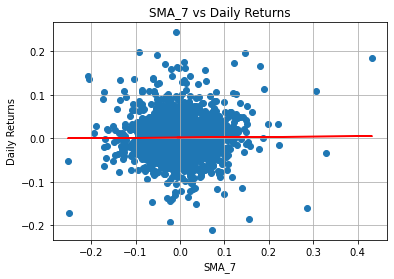

Correlation coefficient between SMA_20 and daily returns:  -0.010018182066831761


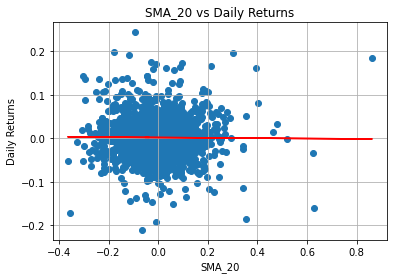

Correlation coefficient between SMA_50 and daily returns:  -0.0005803550766494597


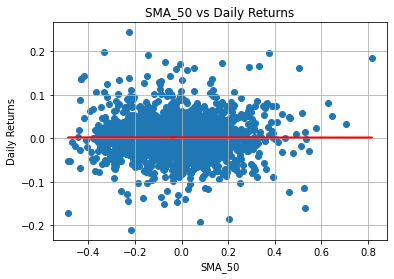

Correlation coefficient between RSI_14 and daily returns:  0.02043015286317532


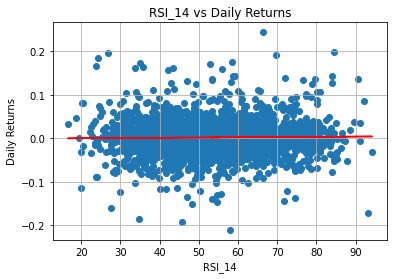

Correlation coefficient between ADX_14 and daily returns:  0.04442349400491918


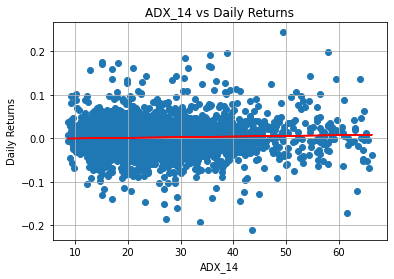

Correlation coefficient between DMP_14 and daily returns:  0.024153869050914482


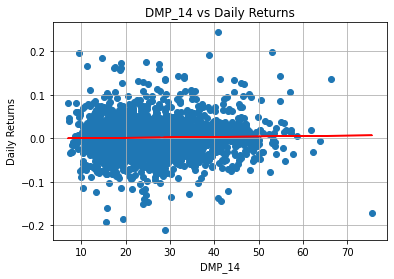

Correlation coefficient between Return_L1 and daily returns:  -0.012601878515051946


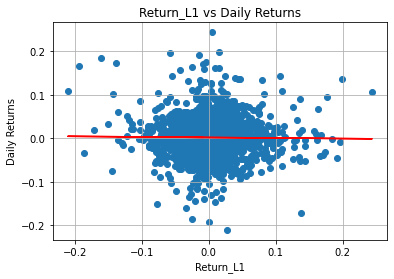

In [594]:
indicators = ["SMA_7", "SMA_20", "SMA_50", "RSI_14", "ADX_14", "DMP_14", "Return_L1"]

for indi in indicators:
    corr_ind_ret(df, indi)

# XGB Regression

## Indicators

In [595]:
# data preprocessing for regression

time_step = 1
train_split = 0.8
all_split = int(len(df) * train_split)
columns = indicators+['Return']
df = df[columns]
retL1_col = df.pop('Return_L1')
df.insert(len(df.columns), 'Return_L1', retL1_col)
ret_col = df.pop('Return')
df.insert(len(df.columns), 'Return', ret_col)
data = df.copy()
data = np.array(data.reset_index(drop=True))
# scale with training data only
train_set = scaler.fit_transform(data[:all_split])
# here val_set is the entire set, then later we only test on exclusive validation period
val_set = scaler.transform(data)
val_set = scaler.transform(data)

X_train, y_train = train_set[:,:-1][:all_split], train_set[:,-1][:all_split]
X_val, y_val = val_set[:,:-1], val_set[:,-1]

In [596]:
reg = xgb.XGBRegressor(objective='reg:squarederror')
reg.fit(np.squeeze(X_train), y_train, verbose=False)  # Change verbose to True if you want to see it train

# predicting response
y_hat = reg.predict(np.squeeze(X_val))
val_set[:,-1] = y_hat
y_hat = scaler.inverse_transform(val_set)[:,-1] # inverse transformation

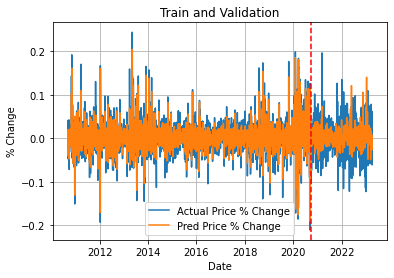

Validation Performance Metrics with Indicators ['SMA_7', 'SMA_20', 'SMA_50', 'RSI_14', 'ADX_14', 'DMP_14', 'Return_L1']
MAE:  0.0323
MSE:  0.0018
RMSE:  0.0429


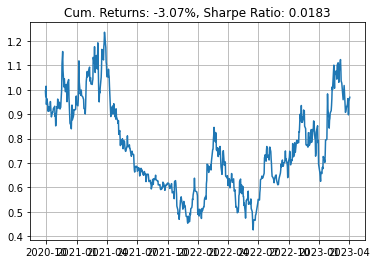

In [597]:
# plotting actual and predicted Adj Close price of random ticker
plt.plot(df.index, df['Return'], label='Actual Price % Change')
plt.plot(df.index, y_hat, label='Pred Price % Change')
plt.axvline(x=df.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title(f'Train and Validation')
plt.legend()
plt.show()

print(f'Validation Performance Metrics with Indicators {indicators}')
print("MAE: ",round(MAE(df['Return'][all_split:], y_hat[all_split:]),4))
print("MSE: ",round(MSE(df['Return'][all_split:], y_hat[all_split:]),4))
print("RMSE: ",round(RMSE(df['Return'][all_split:], y_hat[all_split:]),4))

returns = np.where(y_hat[all_split:]>0,df['Return'][all_split:],
                   np.where(y_hat[all_split:]<0,-df['Return'][all_split:],np.nan))
returns = returns[~np.isnan(returns)]
cumreturns = np.cumprod(1+returns)

plt.plot(df.index[all_split:], cumreturns, label='Cum. Returns')
plt.title(f"Cum. Returns: {round((cumreturns[-1]-1)*100,2)}%, Sharpe Ratio: {round(returns.mean()/returns.std(),4)}")
plt.xticks(rotation=90)
plt.show()

## L1 Return

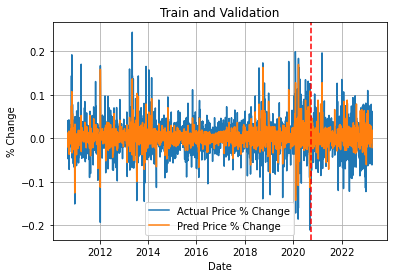

Validation Performance Metrics with Indicator 'Return_L1'
MAE:  0.0318
MSE:  0.0018
RMSE:  0.042


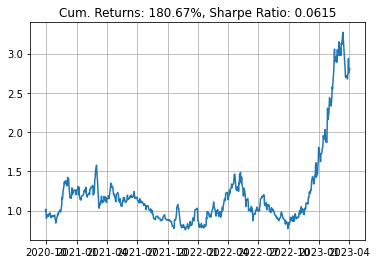

In [598]:
reg.fit(X_train[:,-1].reshape(-1,1), y_train, verbose=False)  # Change verbose to True if you want to see it train

# predicting response
y_hat = reg.predict(X_val[:,-1].reshape(-1,1))
val_set[:,-1] = y_hat
y_hat = scaler.inverse_transform(val_set)[:,-1] # inverse transformation

# plotting actual and predicted Adj Close price of random ticker
plt.plot(df.index, df['Return'], label='Actual Price % Change')
plt.plot(df.index, y_hat, label='Pred Price % Change')
plt.axvline(x=df.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title(f'Train and Validation')
plt.legend()
plt.show()

print(f"Validation Performance Metrics with Indicator 'Return_L1'")
print("MAE: ",round(MAE(df['Return'][all_split:], y_hat[all_split:]),4))
print("MSE: ",round(MSE(df['Return'][all_split:], y_hat[all_split:]),4))
print("RMSE: ",round(RMSE(df['Return'][all_split:], y_hat[all_split:]),4))

returns = np.where(y_hat[all_split:]>0,df['Return'][all_split:],
                   np.where(y_hat[all_split:]<0,-df['Return'][all_split:],np.nan))
returns = returns[~np.isnan(returns)]
cumreturns = np.cumprod(1+returns)

plt.plot(df.index[all_split:], cumreturns, label='Cum. Returns')
plt.title(f"Cum. Returns: {round((cumreturns[-1]-1)*100,2)}%, Sharpe Ratio: {round(returns.mean()/returns.std(),4)}")
plt.xticks(rotation=90)
plt.show()

## Buy & Hold

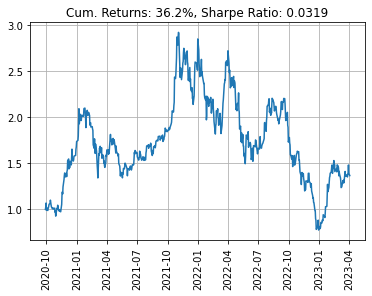

In [600]:
returns = df['Return'][all_split:]
returns = returns[~np.isnan(returns)]
cumreturns = np.cumprod(1+returns)

plt.plot(df.index[all_split:], cumreturns, label='Cum. Returns')
plt.title(f"Cum. Returns: {round((cumreturns[-1]-1)*100,2)}%, Sharpe Ratio: {round(returns.mean()/returns.std(),4)}")
plt.xticks(rotation=90)
plt.show()